# Tutorial notebook: detecting wavelengths of various mediums

#### The following notebook provides example code on how to pull and analyze raw data from the Lumos device for various wavelengths of different mediums. 

Literature: *link*

## 0. Imports

In [69]:
from matplotlib import pyplot as plt, cm, rcParams
from scipy.interpolate import griddata
import pandas as pd
import numpy as np

from scipy.signal import find_peaks

from Data.pull_data import process_df

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## 1. Import, process, and visualize LED, PD, and medium data

### 1.1 Import LED and PD Data

In [70]:
# Import LED and PD Data 

led_path = 'Data/LEDs_watch.csv'
pd_path = 'Data/PDs.csv'

led_df = pd.read_csv(led_path)
pd_df = pd.read_csv(pd_path)

In [71]:
led_df.head()

,Wavelength,FWHM,Hex_Code,Notes
0,415,20,#7600ed,NaN
1,450,20,#0046ff,NaN
2,470,20,#00a9ff,NaN
3,530,30,#1fff00,NaN
4,568,100,#92ff00,NaN


In [72]:
pd_df.head()

,Wavelength,FWHM,Hex_Code,Notes
0,415,26,#7600ed,NaN
1,445,30,#0028ff,NaN
2,480,36,#00d5ff,NaN
3,515,39,#1fff00,NaN
4,555,39,#b3ff00,NaN


### 1.2 Import Medium Data and Process

The next few cells will import the medium reading and determine start and end time for each LED - this is currently hardcoded. In the future, the device will output data with a label for what LED was on at what time.

In [73]:
# Select color you would like to analyze
# Options: air, blue, green, orange, purple, red, yellow
color = 'blue'

# Which col headers to extract
col_headers = ['1', '2', '5']

medium_df = pd.read_csv(f'Data/Medium_Data/{color}.csv', usecols = col_headers)

medium_df.head()

,1,2,5
0,180,1660195979427,6786
1,181,1660195979427,36830
2,182,1660195979427,11014
3,183,1660195979427,7340
4,184,1660195979427,7123


In [74]:
# The process_df function will aggregate the counts for each wavelength at each timestamp.
processed_medium_df = process_df(medium_df)

# Sort by timestamp
processed_medium_df = processed_medium_df.sort_values('timestamp')

# Remove rows if needed
# processed_medium_df = processed_medium_df.iloc[:-150]

processed_medium_df.head()

,timestamp,415_counts,445_counts,480_counts,515_counts,555_counts,590_counts,630_counts,680_counts
642,1660195500423,0,0,0,0,2,4,4,1
641,1660195501039,0,0,0,0,1,3,4,0
640,1660195501656,0,0,0,1,2,3,6,0
639,1660195502272,0,0,2,4,2,4,10,1
638,1660195502891,0,0,1,3,10,11,17,6


### 1.3 Visualize Medium Data

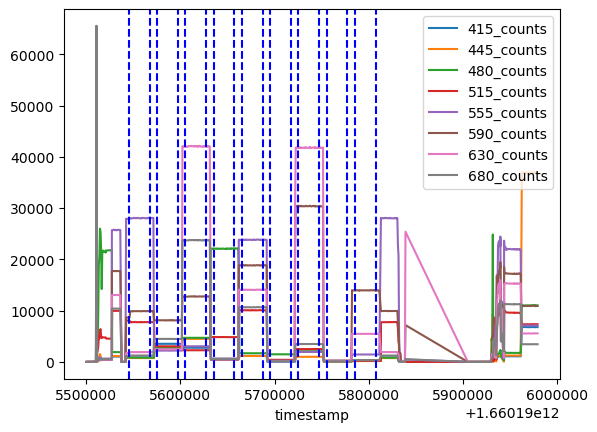

In [75]:
# Order in which LEDs were turned on
led_order = [530, 940, 660, 470, 568, 450, 633, 415, 599]

processed_medium_df.plot(x='timestamp', y=['415_counts','445_counts','480_counts','515_counts','555_counts','590_counts','630_counts','680_counts'])

# Find first timestamp 
xx = processed_medium_df.iloc[0]['timestamp']

# Hard-coded value for start time
xx = xx + 42_000

# Loop through LED wavelengths
for led in led_order:
    
    # Create LED column and assign value between start and end times
    processed_medium_df.loc[processed_medium_df.timestamp.between(xx + 3000, xx + 25000), 'LED'] = led
    
    # Plot straight line for spectral response
    plt.axvline(x=xx+3000, color='b', ls='--')
    plt.axvline(x=xx+25000, color='b', ls='--')
    
    # Loop through every 30,000 samples
    xx = xx + 30_000

plt.show()

### 1.4 Process dataframe to get counts per LED

In [76]:
# Drop nulls
temp_df = processed_medium_df[processed_medium_df['LED'].notna()].copy()

# Convert LED col to int
temp_df['LED'] = temp_df['LED'].astype(int).copy()

# Drop timestamp col
temp_df = temp_df.drop(['timestamp'], axis=1).copy()

final_df = pd.DataFrame()

# Iterate through LEDs and get mean values for each LED value
for led in led_df.Wavelength:
    working_df = pd.DataFrame(temp_df.loc[temp_df['LED'] == (led)].mean().to_dict(),index=[temp_df.index.values[-1]])
    final_df = pd.concat([final_df, working_df], axis=0)

final_df.head()

,415_counts,445_counts,480_counts,515_counts,555_counts,590_counts,630_counts,680_counts,LED
168,55.885714,13.771429,76.800000,202.771429,240.485714,210.771429,138.971429,96.200000,415.0
168,33.500000,329.764706,1482.735294,407.235294,247.558824,206.382353,128.647059,125.205882,450.0
168,415.771429,503.257143,22085.314286,4840.085714,670.314286,402.914286,463.285714,565.171429,470.0
168,852.852941,759.705882,832.147059,7784.852941,28033.882353,9794.852941,1897.970588,1244.411765,530.0
168,1157.944444,1162.083333,1694.083333,10076.000000,23819.500000,18836.000000,14067.888889,10663.194444,568.0


In [77]:
# Drop LED col and convert to np array for processing
temp_df = final_df.drop(['LED'], axis=1)
exp_arr = temp_df.to_numpy()

exp_arr[0]

array([ 55.88571429,  13.77142857,  76.8       , 202.77142857,
       240.48571429, 210.77142857, 138.97142857,  96.2       ])

## 2. Calculate Spectral Response

### 2.1 Load Theoretical Approx Data and calculate response

In [79]:
theory_path = 'Data/Medium_Data/theory_arr.csv'

# Load Data
theory_areas = np.loadtxt(theory_path, delimiter = ",")

# Subtract experimental data with theoretical approx
med_arr = np.subtract(exp_arr, theory_areas)
med_arr = med_arr * -1

### 2.2 Plot Spectral Response in 3D Space

In [80]:
# Choose method of interpolation
# Options: mearest, linear, cubic, etc.

method = 'cubic'

Text(0.5, 0.92, 'Blue')

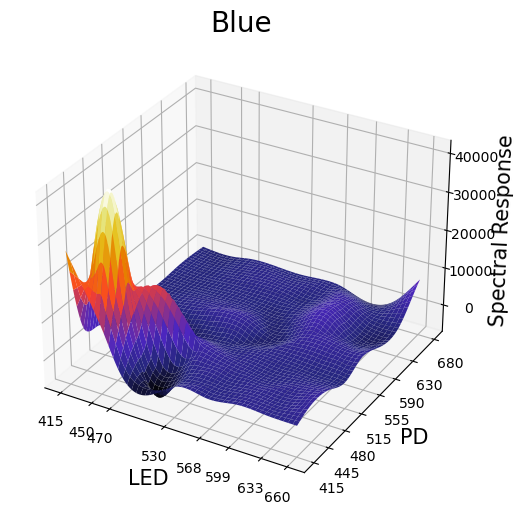

In [86]:
# Initialize objects
fig = plt.figure(figsize=(7,6))
ax = plt.axes(projection='3d')

# Construct axises for 3D representation
X = np.array(led_df.Wavelength.tolist()*len(pd_df.Wavelength.tolist()))
Y = np.array(np.repeat(pd_df.Wavelength.tolist(), len(led_df.Wavelength.tolist())))
Z = np.array([item for sublist in med_arr for item in sublist])

# Find mins and maxes
x_min = X.min()
x_max = X.max()
y_min = Y.min()
y_max = Y.max()

# Create linearly spaced arrays between min and maxes
x_new = np.linspace(x_min, x_max, 600)
y_new = np.linspace(y_min, y_max, 600)

# Construct new axises
z_new = griddata((X, Y), Z, (x_new[None,:], y_new[:,None]), method=method)
x_new_grid, y_new_grid = np.meshgrid(x_new, y_new)

# Plot
surf = ax.plot_surface(x_new_grid, y_new_grid, z_new, cmap=cm.CMRmap)

# Options
ax.set_xticks(led_df.Wavelength.tolist())
ax.set_yticks(pd_df.Wavelength.tolist())
ax.set_xlabel('LED',size=15)
ax.set_ylabel('PD',size=15)
ax.set_zlabel('Spectral Response',size=15)
ax.set_title(color.capitalize(), size=20)

### 2.3 Calculate max for each axis

In [84]:
prominence = (15000, 65535)

In [90]:
# Get unraveled arrays for calculation
z_new2 = np.array(np.ravel(z_new))
y_new2 = np.array(np.ravel(y_new_grid))
x_new2 = np.array(np.ravel(x_new_grid))

# Find peaks for z axis
peaks, _ = find_peaks(z_new2, prominence=prominence)
peaks

array([  600,  1200,  1800,  2400,  3000,  3600,  4200,  4800,  5400,
        6000,  6600,  7200,  7800,  8400,  9000,  9680, 10280, 10880,
       11480, 12080, 12680, 13280, 13880, 14480, 15080, 15679, 16279,
       16879, 17479, 18079, 18679, 19279, 19879, 20479, 21079, 21679,
       22279, 22879, 23479, 24079, 24679, 25279, 25879, 26479, 27079,
       27679, 28279, 28879, 29479, 30079, 30679, 31278, 31878, 32478,
       33078, 33678, 34278, 34878, 35478, 36078, 36678, 37278, 37878,
       38477, 39077, 39677, 40276, 40876, 41476, 42075, 42675, 43275,
       43874, 44474, 45074, 45673, 46273, 46872, 47472, 48072, 48671,
       49271, 49871, 50471, 51070, 51670, 52270, 52870, 53470, 54070,
       54669, 55269, 55869, 56469, 57069, 57669, 58269, 58869, 59469,
       60069, 60669, 61269, 61869, 62469, 63069, 63669, 64269, 64869,
       65469, 66069, 66669, 67269, 67870, 68470, 69070, 69670, 70271,
       70871, 71471, 72072, 72672, 73273, 73873, 74474, 75074, 75675,
       76276, 76876,

In [93]:
# Delete peaks that are less than 0 from peaks and z-axis arrays

new_peaks = peaks

for i in range(0, len(peaks)):
    #print(z_new2[peaks[i]])
    if(z_new2[peaks[i]]) < 0:
        #print(peaks[i])
        z_new2 = np.delete(z_new2, int(z_new2[peaks[i]]))
        new_peaks = np.delete(peaks, i)

new_peaks

array([  600,  1200,  1800,  2400,  3000,  3600,  4200,  4800,  5400,
        6000,  6600,  7200,  7800,  8400,  9000,  9680, 10280, 10880,
       11480, 12080, 12680, 13280, 13880, 14480, 15080, 15679, 16279,
       16879, 17479, 18079, 18679, 19279, 19879, 20479, 21079, 21679,
       22279, 22879, 23479, 24079, 24679, 25279, 25879, 26479, 27079,
       27679, 28279, 28879, 29479, 30079, 30679, 31278, 31878, 32478,
       33078, 33678, 34278, 34878, 35478, 36078, 36678, 37278, 37878,
       38477, 39077, 39677, 40276, 40876, 41476, 42075, 42675, 43275,
       43874, 44474, 45074, 45673, 46273, 46872, 47472, 48072, 48671,
       49271, 49871, 50471, 51070, 51670, 52270, 52870, 53470, 54070,
       54669, 55269, 55869, 56469, 57069, 57669, 58269, 58869, 59469,
       60069, 60669, 61269, 61869, 62469, 63069, 63669, 64269, 64869,
       65469, 66069, 66669, 67269, 67870, 68470, 69070, 69670, 70271,
       70871, 71471, 72072, 72672, 73273, 73873, 74474, 75074, 75675,
       76276, 76876,

In [101]:
# This cell calculates the max values for each axis. 

array_temp = []
array_temp_peak = []
array_temp_peak_MAX = []
array_temp_MAX = []
temp_peaks = new_peaks

# If we have peaks
if len(temp_peaks):
    for j in range(1, len(temp_peaks)):
        
        # Check if the array is increasing
        if z_new2[temp_peaks[j]] - z_new2[temp_peaks[j - 1]] > 0: 
            array_temp.append(z_new2[temp_peaks[j - 1]])
            array_temp_peak.append(temp_peaks[j - 1])
        
        # Check if array is decreasing
        elif z_new2[temp_peaks[j]] - z_new2[temp_peaks[j - 1]] < 0: 
            
            # Skip only if the array is decreasing from the beginning 
            if len(array_temp) == 0:
                continue
            
            # Append to temp arrays
            else:
                array_temp_MAX.append(max(array_temp))
                array_temp_peak_MAX.append(max(array_temp_peak))
                # Reset temp arrays
                array_temp = []
                array_temp_peak = []
            
            if j == len(temp_peaks):
                temp_peaks = []
                
            else:
                j = 0
                temp_peaks = temp_peaks[j:len(temp_peaks)]

        if j == len(temp_peaks):
            temp_peaks = []

In [99]:
print(f"z values MAX: {array_temp_MAX}")
print('')
print(f"y values MAX:")
for m in range(0, len(array_temp_peak_MAX)):
    print(y_new2[array_temp_peak_MAX[m]])
print('')
print("x values MAX")
for n in range(0, len(array_temp_peak_MAX)):
    print(x_new2[array_temp_peak_MAX[n]])

z values MAX: [42315.055219838185, 16155.680417226466]

y values MAX:
444.19866444073455
477.3789649415693

x values MAX
446.49415692821367
476.7612687813022


In [100]:
# Save figure
fig.savefig(f"Figures/{color}.pdf", bbox_inches='tight')